# Computer Vision - Project
imports

In [228]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py, requests, os
import matplotlib.patches as patches

In [229]:
# IMG_SIZE = (64, 64)
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.resnet(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
# base_model.trainable = False

Constants

In [230]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()


In [231]:
def sort_points(points, center):
    # calculate the angle of each point from the center point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    # sort the points by angle
    sorted_points = points[np.argsort(angles)]
    return sorted_points

In [232]:
def draw_points(image, points, color=(255, 0, 0), radius=3):
    # create a copy of the image
    img = image.copy()
    # iterate over the points and draw them on the image
    for point in points:
        cv2.circle(img, tuple(map(int, point)), radius, color, -1)
    return img


In [233]:
def get_bb(img, bbs, indx):
    x1 = int(bbs[0,0,indx])
    y1 = int(bbs[1,0,indx])
    x2 = int(bbs[0,1,indx])
    y2 = int(bbs[1,1,indx])
    x3 = int(bbs[0,2,indx])
    y3 = int(bbs[1,2,indx])
    x4 = int(bbs[0,3,indx])
    y4 = int(bbs[1,3,indx])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))
    points = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    
    # create an empty image with the same shape as the input image
    mask = np.zeros_like(img)
    # create a list of the bounding box points in the correct format
    bounding_box = np.array([points], dtype=np.int32)
    # fill the area inside the bounding box with white
    cv2.fillPoly(mask, bounding_box, (255, 255, 255))
    # apply the mask to the image
    ####res = cv2.bitwise_and(img, mask)
    # try1 = np.array(np.where(mask == 255, 255, 0), dtype=np.uint8)
    # print(x)
    # inv_mask = cv2.bitwise_not(mask)
    # res2 = cv2.bitwise_and(img, inv_mask)
    # bb2 = np.int32([[top_left_x, bot_right_y], [bot_right_x, bot_right_y],[bot_right_x,top_left_y], [top_left_x,top_left_y]])
    # print(bb2)
    # mask2 = np.zeros_like(img)
    # # bb2 = np.array(frame, dtype=np.int32)
    # cv2.fillPoly(mask2, bb2, (255, 255, 255))
    mask = mask[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

    #res = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    #flipping
    """"if(x2 < x1):
        res = cv2.flip(res, 1)
    if(y2 < y1):
        res = cv2.flip(res, 0)
    plt.imshow(mask)
    plt.show()
    print(mask.shape)"""
    return res, mask

In [234]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Titillium Web':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Open Sans':
        return 3
    else:
        return 4

In [249]:
def prepare_img(img, bbs, index, size):
    cropped, mask = get_bb(img, bbs, index)
    # cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # cropped = tf.image.resize(cropped, (size, size))
    # cropped = tf.image.rgb_to_grayscale(cropped)
    blurred = cv2.GaussianBlur(cropped,(3,3),0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY).squeeze().astype(np.uint8)
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY).squeeze().astype(np.uint8)
    
    # print(np.array(cropped).squeeze().shape)
    # print('---------------------------------------------------------------')
    
    # print(blurred.dtype)
    # if (img.dtype == cv2.CV_8U):
    img_laplacian = cv2.Laplacian(np.array(gray),cv2.CV_8U)
    # else:
    #     img_laplacian = cv2.Laplacian(np.array(blurred),cv2.CV_64F)
    # print(img_laplacian)
    # print(gray_mask)
    # print(img_laplacian)
    # print(gray_mask)
    res = cv2.bitwise_and(img_laplacian, gray_mask)
    # res = tf.image.convert_image_dtype(res, tf.float32)
    # res = tf.image.resize(res, (size, size))
    res = cv2.resize(res, (64,64),interpolation = cv2.INTER_AREA)
    # plt.imshow(res, cmap='gray')
    # plt.show()
    # res = get_bb(res, bbs, index)
    # res = tf.image.convert_image_dtype(res, tf.float32)
    # cropped = tf.image.resize(cropped, (size, size))
    # cropped = tf.image.rgb_to_grayscale(cropped)
    return res.reshape((64,64,1))

In [250]:
def get_data_set(size: int):
    db = h5py.File(FILE_NAME, 'r')
    im_names = list(db['data'].keys())
    train_x = []
    train_y = []
    for i in range(0, len(im_names)-1):
        im = im_names[i]
        img  = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txts = db['data'][im].attrs['txt']
        charBBs = db['data'][im].attrs['charBB']
        wordBBs = db['data'][im].attrs['wordBB']
        font_indx = 0 
        char_indx = 0
        for j in range(0, len(txts)):
            cropped = prepare_img(img, wordBBs, j, size)
            train_x.append(cropped)
            train_y.append(font_to_num(fonts[font_indx]))
            font_indx += len(txts[j])
            #plt.imshow(cropped)
            #plt.show()
            for k in range(0, len(txts[j])):
                cropped = prepare_img(img, charBBs, char_indx, size)
                train_x.append(cropped)
                train_y.append(font_to_num(fonts[char_indx]))
                char_indx+=1
                #plt.imshow(cropped)
                #plt.show()
    return train_x, train_y

In [251]:
train_x, train_y = get_data_set(64)

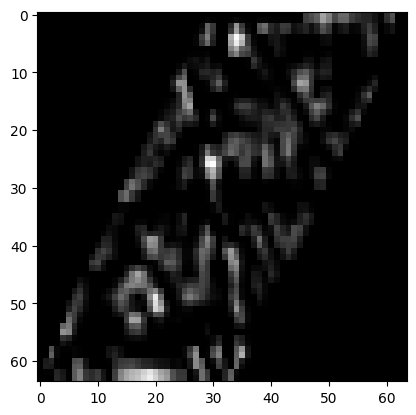

In [252]:
# train_X = np.asarray(train_x, dtype="float") / 255.0
plt.imshow(train_x[3], cmap='gray')
# print(train_x)

In [253]:
#cut the set for train and validation
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [254]:
Y_train = np_utils.to_categorical(y_train, 5)
Y_test = np_utils.to_categorical(y_test, 5)

In [255]:
# model = Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#   tf.keras.layers.RandomRotation(0.2),
# ])
from keras.layers import RandomFlip, RandomRotation
model = Sequential()
model.add(RandomFlip("horizontal_and_vertical"))
# model.add(RandomRotation(0.1))
model.add(Convolution2D(32, 3, 3, activation='relu', padding='same', input_shape=(64,64,1)))
model.add(Convolution2D(32, 3, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [256]:

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [257]:
X_train = np.array(x_train)
Y_train = np.array(Y_train)
# print(X_train.shape)
# print(Y_train.shape)
# plt.imshow(X_train[2], cmap='gray')


In [258]:
# X_train = np.array(x_train, dtype='uint8')
print(X_train.shape)
print(Y_train.shape)

(30321, 64, 64, 1)
(30321, 5)


In [259]:
model.fit(X_train, Y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
 904/1896 [=============>................] - ETA: 14s - loss: 1.6072 - accuracy: 0.2745

In [ ]:
X_test = np.array(x_test)
#np.random.shuffle(Y_test)
score = model.evaluate(X_test, Y_test, verbose=0)

In [ ]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.6114404201507568 / Test accuracy: 0.3215934634208679


In [ ]:
# res = model.predict(X_train[:7])
# print(res) 0.41419339179992676

In [ ]:
# print(Y_train[:7])

In [ ]:
#del model 
#tf.keras.backend.clear_session()